In [2]:
import numpy as np                     # To handle arrays
import matplotlib.pyplot as plt        # To show plots
import sklearn                         # To use the sklearn library
import sklearn.datasets as ds          # To load datasets
import sklearn.model_selection as cv   # For Cross Validation
import sklearn.neighbors as nb         # To use KNN

from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    validation_curve,
)
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
)
from sklearn.svm import (
    LinearSVC, 
    SVC,
)
from sklearn.ensemble import (
    ExtraTreesClassifier, 
    AdaBoostClassifier, 
    BaggingClassifier,
)
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    make_scorer, 
    confusion_matrix,
)

%matplotlib inline

In [3]:
import numpy as np    # Numeric and matrix computation
import pandas as pd   # Optional: good package for manipulating data 
import sklearn as sk  # Package with learning algorithms implemented

df = pd.read_csv("data_balanced_normalized.csv", na_values=['NA', 'N/A'])
# df = pd.read_csv("data_balanced_normalized.csv", nrows=num_rows_to_read)
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,-0.191687,-0.611612,-0.473831,0.819943,1.807022,-0.733750,1.527153,1.243393,0.098037,-0.851704,...,0.81734,1.224544,-0.812739,0.816858,1.528958,-0.998836,-0.498499,0.996715,0.495654,0
1,-0.445728,-0.611612,-0.473831,-0.325946,-0.553397,1.350383,-0.654813,-0.882546,1.367177,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,1.001166,2.006022,-1.003296,-2.017536,0
2,0.231714,-0.611612,-0.473831,0.896336,-0.553397,-1.408028,-0.654813,1.568211,1.099990,-0.249521,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
3,-1.885292,-0.611612,-0.473831,-0.147697,-0.553397,-1.162836,1.527153,0.875027,1.033193,-2.557890,...,-1.22348,-0.816630,-0.812739,0.816858,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
4,-0.530408,-0.611612,-0.473831,-1.650085,-0.553397,-0.978942,-0.654813,0.062720,0.565615,0.352663,...,0.81734,1.224544,-0.812739,-1.224203,-0.654040,1.001166,-0.498499,0.996715,0.495654,0


Let's separate the data into training (for adjusting parameters), and validation.

In [4]:

# Splitting the dataset COMPLETE into features and labels
y = df['heart_attack']
X = df.drop(columns=['heart_attack'])

(X_train, X_test,  y_train, y_test) = cv.train_test_split(
    X, y, test_size=.5, stratify = y,random_state=1 
)
df.describe()

# Sample the data LITTLE to have a manageable size for training
sampled_data, _ = cv.train_test_split(
    df,
    train_size=30000,
    stratify=df['heart_attack'],
    random_state=1

)

# Separate features and target variable
y_sampled = sampled_data['heart_attack']
X_sampled = sampled_data.drop(columns=['heart_attack'])


# Split the sampled data into training and testing sets
(X_train_sample, X_test_sample, y_train_sample, y_test_sample) = cv.train_test_split(
    X_sampled, y_sampled, test_size=0.5, stratify=y_sampled, random_state=1 # random_state always with the same fixed value -> data split always the same; random_state = none -> each execution
)

### Sampling for Optimisation
We create a smaller sample (30,000 records) to speed up hyperparameter search. This technique is especially useful for large datasets where GridSearch would be prohibitively slow.

Advantages of stratified sampling:** ** Maintains the original distribution of classes.
- Maintains the original distribution of classes
- Significantly reduces training time
- Allows more hyperparameters to be explored in less time

In [5]:
from IPython.display import display, HTML

# Function that converts the report to a DataFrame
def reportClassesDataframe(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

# Function that converts the report to a DataFrame
def reportAccuracyDF(report):
  report = [x.split('      ') for x in report.split('\n')]
  values = []
  report[6].pop(2)
  df = pd.DataFrame(report[6:9])
  return df

# Function that shows the report in a pretty way
def prettyReport(report):
    df = reportClassesDataframe(report)
    display(HTML(df.to_html(index=False,justify="center")))
    df2 = reportAccuracyDF(report)
    
    print("\n")
    display(HTML(df2.to_html( header=False,index=False,justify="center")))
    df
    df2
    return

#Function that shows the confusion matrix with a pretty Layout
def prettyConfusionMatrix(confmat):
  fig, ax = plt.subplots(figsize=(2.5, 2.5))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  plt.savefig('ConMatrix.png', dpi=600)
  plt.show()
  return

# Function to print classification report and return accuracy score
from sklearn.metrics import classification_report, accuracy_score
def classification_report_with_accuracy_score(y_true, y_pred):

    print(classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [5]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler = StandardScaler().fit(X_train)
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

# Apply the normalization trained in training data in both training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### Linear SVM
Let's try an SVM with default parameters. Linear means that we are not using any kernel to move the data to a higher dimensional space.

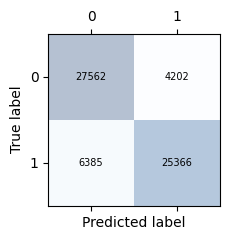


Accuracy on test set:  0.833314964968905


Class Name,precision,recall,f1-score,support
0,0.81,0.87,0.84,31764
1,0.86,0.80,0.83,31751


macro avg,0.83,0.83 63515,None
weighted avg,0.83,0.83,0.83 63515
,None,None,None


Confusion matrix on test set: 
[[27562  4202]
 [ 6385 25366]]
Accuracy on test set: 0.833314964968905
Accuracy     : 0.833  (95% CI 0.830 – 0.836)
Precision (1): 0.858  (95% CI 0.854 – 0.862)
Recall    (1): 0.799  (95% CI 0.794 – 0.803)

Normal-approximation acceptable for accuracy?: True


In [5]:
#knc = LinearSVC() 
knc = SVC(kernel = "linear")
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)
prettyConfusionMatrix(confusion_matrix(y_test, prediction))
print("\nAccuracy on test set: ",accuracy_score(y_test, prediction))
prettyReport(classification_report(y_test, prediction))

print(f"Confusion matrix on test set: \n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"Accuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

# ------------------------------------------------------------------
# 1. point estimates
# ------------------------------------------------------------------
acc      = accuracy_score(y_test, prediction)
prec_pos = precision_score(y_test, prediction, pos_label=1)
rec_pos  = recall_score(y_test, prediction,    pos_label=1)

# ------------------------------------------------------------------
# 2. raw counts needed for CIs
# ------------------------------------------------------------------
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
n_total   = tp + tn + fp + fn         # == len(y_test)

# ------------------------------------------------------------------
# 3. 95 % CIs (Wilson score by default)
# ------------------------------------------------------------------
acc_ci   = proportion_confint(count=tp + tn, nobs=n_total,   alpha=0.05, method="wilson")
prec_ci  = proportion_confint(count=tp,       nobs=tp + fp,  alpha=0.05, method="wilson")
rec_ci   = proportion_confint(count=tp,       nobs=tp + fn,  alpha=0.05, method="wilson")

# ------------------------------------------------------------------
# 4. Optional: check if the normal approximation is safe for accuracy
#    Rule of thumb: n·p·(1-p) ≥ 5
# ------------------------------------------------------------------
normal_ok = n_total * acc * (1 - acc) >= 5

# ------------------------------------------------------------------
# 5. nicely formatted output
# ------------------------------------------------------------------
print(f"Accuracy     : {acc:.3f}  (95% CI {acc_ci[0]:.3f} – {acc_ci[1]:.3f})")
print(f"Precision (1): {prec_pos:.3f}  (95% CI {prec_ci[0]:.3f} – {prec_ci[1]:.3f})")
print(f"Recall    (1): {rec_pos:.3f}  (95% CI {rec_ci[0]:.3f} – {rec_ci[1]:.3f})")
print("\nNormal-approximation acceptable for accuracy?:", normal_ok)

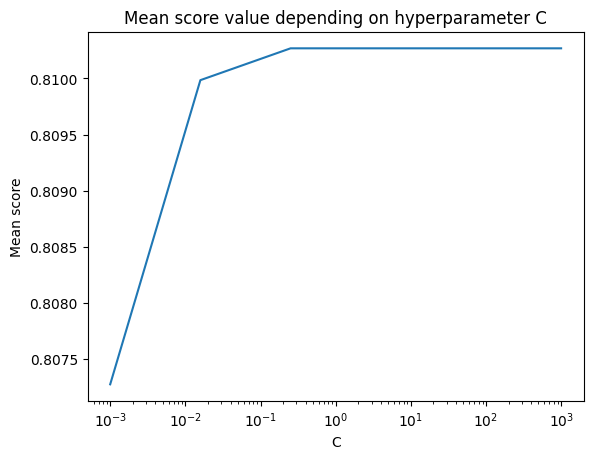

Best C found: 0.25118864315095796


Class Name,precision,recall,f1-score,support
0,0.82,0.86,0.84,31764
1,0.85,0.81,0.83,31751


macro avg,0.83,0.83 63515,None
weighted avg,0.83,0.83,0.83 63515
,None,None,None


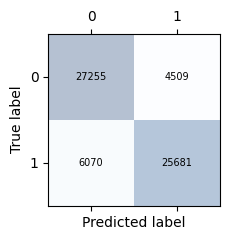


Confusion matrix on test set:
 [[27255  4509]
 [ 6070 25681]]

Accuracy on test set: 0.8334409194678423

Best value of parameter C found: {'C': np.float64(0.25118864315095796)}
Model coefficients shape: (1, 33)


In [6]:
# List of C values to test. We usualy test diverse orders of magnitude
#Cs = np.logspace(-3, 11, num=15, base=10.0)
Cs = np.logspace(-3, 3, num = 6, base = 10.0)   # Reduced range for faster computation

param_grid = {"C": Cs}
# grid_search = GridSearchCV(LinearSVC(), param_grid, cv=3)
grid_search = GridSearchCV(
    LinearSVC(max_iter=2000, dual=False),   # Much faster than SVC with linear kernel
    param_grid, 
    cv = 3,
    scoring= "recall",  # We want to optimize recall
    n_jobs= -1  # Use all available cores for parallel processing	 
)
grid_search.fit(X_train, y_train)

# Let's plot the 3-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_["mean_test_score"]
plt.title("Mean score value depending on hyperparameter C")
plt.xlabel("C")
plt.ylabel("Mean score")
plt.semilogx(Cs,scores)
plt.show()
  
parval=grid_search.best_params_
# cvacc = cross_val_score(
#     SVC(C = parval["C"], kernel = "linear"), 
#     X = X_train_sample,
#     y = y_train_sample, 
#     cv = 3, 
#     scoring = "recall",
#     n_jobs = -1  # Use all available cores for parallel processing
# )
# print(f"Acc. 3-fold cross on train data = {cvacc.mean()}")
print(f"Best C found: {parval['C']}")

# Let's apply the best C parameter found to the test set
knc = LinearSVC(C=parval['C'], max_iter=2000, dual=False)  
# knc = SVC(
#     C = parval["C"],
#     kernel = "linear"
# )
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

prettyReport(sklearn.metrics.classification_report(y_test, prediction))
prettyConfusionMatrix(sklearn.metrics.confusion_matrix(y_test, prediction))

print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"\nBest value of parameter C found: {parval}")
print(f"Model coefficients shape: {knc.coef_.shape}")
# print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")

# print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")


**Search Strategy:** 
**Parameter C**: Controls the trade-off between maximum margin and correct ranking
- Parameter C**: Controls the trade-off between maximum margin and correct classification.
  - C small: Large margin, can under-adjust
  - Large C: Small margin, can over-adjust

Implemented optimisations:** ** Reduced C range: [-3
- Reduced range of C: [-3, 3] in logarithmic scale (vs [-3, 11] original)
- LinearSVC instead of SVC(kernel=“linear”): much faster
- max_iter=2000: Prevents overflow errors
- dual=False: More efficient for n_samples > n_features
- n_jobs=-1: Full parallelisation
- scoring=“recall”: Optimise to detect positive cases

In [7]:
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    """Plot validation curve.
    Parameters: 
    parameter_values (List[float])  : x-axis values. Paramether that change during execution.
    train_scores     (List[float])  : results on train set.
    test_scores      (List[float])  : results on test set.
    
    Returns:
    None
    """
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)
    validation_scores_std = np.std(validation_scores, axis = 1)

    plt.fill_between(
        x = parameter_values, 
        y1 = train_scores_mean - train_scores_std,
        y2 = train_scores_mean + train_scores_std, 
        alpha = 0.1,
        color = "r"
    )
    plt.fill_between(
        x = parameter_values,
        y1 = validation_scores_mean - validation_scores_std,
        y2 = validation_scores_mean + validation_scores_std, 
        alpha = 0.1, 
        color = "g"
    )
    plt.plot(
        parameter_values, 
        train_scores_mean, 
        "o-", 
        color = "r",
        label = "Training score"
    )
    plt.plot(
        parameter_values, 
        validation_scores_mean, 
        "o-", 
        color = "g",
        label = "Cross-validation score"
    )
    plt.ylim(
        validation_scores_mean.min() - .1, 
        train_scores_mean.max() + .1
    )
    plt.legend(loc = 4)

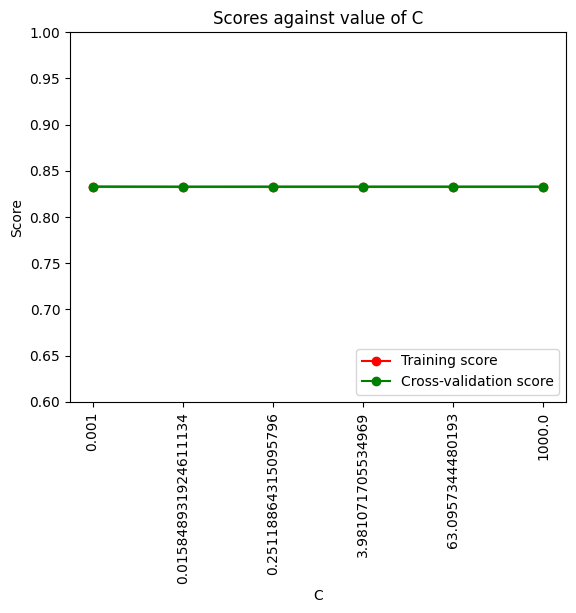

In [8]:
training_scores, test_scores = validation_curve(
    LinearSVC(max_iter=2000),
    X_train, 
    y_train, 
    param_name = "C", 
    param_range = Cs,
    cv = 3
)
# Create the plot
plot_validation_curve( 
    range(len(Cs)), 
    training_scores, 
    test_scores
)
plt.xticks(
    range(len(Cs)), 
    Cs,
    rotation = "vertical"
);
plt.ylim([0.6, 1])
plt.title("Scores against value of C")
plt.ylabel("Score")
plt.xlabel("C")
plt.show()

### Polynomial Kernels

We have seen that performance with a linear SVM is Ok but not competitive with Metamethods. However, it could happen that using kernels we could even improve accuracy. We'll try first ploynomial kernel with degree 2 with default parameters.

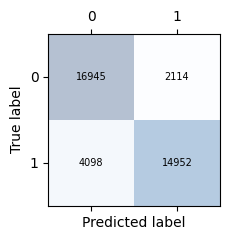

Class Name,precision,recall,f1-score,support
0,0.81,0.89,0.85,19059
1,0.88,0.78,0.83,19050


macro avg,0.84,0.84 38109,None
weighted avg,0.84,0.84,0.84 38109
,None,None,None


Confusion matrix on test set:
 [[16945  2114]
 [ 4098 14952]]

Accuracy on test set: 0.8369938859586974


In [7]:
knc = SVC(
    kernel = "poly",
    degree = 2
) 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)
prettyConfusionMatrix(sklearn.metrics.confusion_matrix(y_test, prediction))
prettyReport(sklearn.metrics.classification_report(y_test, prediction))

print(f"Confusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Better performance than the obtained with a linear SVM... It could even be increased because we didn't tune the C parameter for the polynomial kernel. Let's do that now.

c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


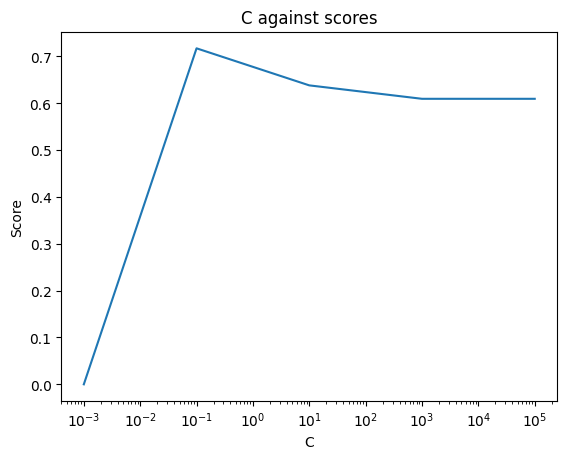

Best C found: 0.1


c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Class Name,precision,recall,f1-score,support
0,0.80,0.80,0.80,7501
1,0.80,0.80,0.80,7499


macro avg,0.80,0.80 15000,None
weighted avg,0.80,0.80,0.80 15000
,None,None,None


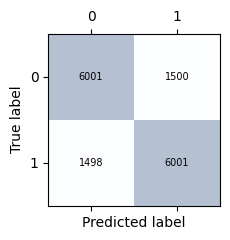


Confusion matrix on test set:
 [[6001 1500]
 [1498 6001]]

Accuracy on test set: 0.8001333333333334

Best combination of parameters found: {'C': np.float64(0.1)}

Number of supports: 9990 (9990 of them have slacks)
Prop. of supports: 0.666


In [16]:
Cs = np.logspace(-3, 5, num = 5, base = 10.0) # Reduced range for faster computation

param_grid = {"C": Cs}
grid_search = GridSearchCV(
    SVC(kernel = "poly",degree = 2, cache_size=2000, max_iter=5000),  # poly kernel with degree 2, 
    param_grid, 
    cv = 3,
    n_jobs = -1,  # Use all available cores for parallel processing
    scoring = "recall",  # We want to optimize recall    
)

# # Sample the training data if it is too large
if X_train_sample.shape[0] > 1000000:
    X_grid_sample, _, y_grid_sample, _ = cv.train_test_split(
        X_train_sample, y_train_sample, 
        train_size=1000000, 
        stratify=y_train_sample, 
        random_state=42
    )
else:
    X_grid_sample, y_grid_sample = X_train_sample, y_train_sample
    
grid_search.fit(X_grid_sample,y_grid_sample)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs, scores)
plt.title("C against scores")
plt.xlabel("C")
plt.ylabel("Score")
plt.show()

parval = grid_search.best_params_

# cvacc = cross_val_score(
#     SVC(kernel='poly',
#     degree =2,C=parval['C']) ,
#     X=X_train_sample, 
#     y=y_train_sample, 
#     cv=3,
#     scoring='recall',
#     n_jobs=-1,  # Use all available cores for parallel processing
# )
# print('Acc. 3-fold cross ona train data= ', cvacc.mean())
print(f"Best C found: {parval['C']}")

knc = SVC(
    kernel='poly',
    degree =2,
    C=parval['C'],
    cache_size=2000,
    max_iter=5000,
    shrinking= True,  # Default value
    tol = 1e-3  # Default value
)  
knc.fit(X_grid_sample, y_grid_sample)
prediction =knc.predict(X_test_sample)

prettyReport(sklearn.metrics.classification_report(y_test_sample, prediction))
prettyConfusionMatrix(sklearn.metrics.confusion_matrix(y_test_sample, prediction))

print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test_sample, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test_sample, prediction)}")
print(f"\nBest combination of parameters found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train_sample.shape[0]}")



Also, we could also try with degree = 3, but due to the high computational time we have decided not to do so.

### RBF Kernel

In [ ]:
knc = SVC() 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)
print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

prettyReport(sklearn.metrics.classification_report(y_test, prediction))
prettyConfusionMatrix(sklearn.metrics.confusion_matrix(y_test, prediction))


Promising performance for default parameters. But we have to search for the best parameters. In this case we have two parameters to adjust: the C parameter and the gamma parameter. We will find the best combination using the GridSearch method.

In [ ]:
# Values we will test for each parameter. When observin results, consider the limits of the 
# values tested and increase them if necessary 
gammas = [0.001, 0.01, 0.1, 1] # Reduced range for faster computation
Cs = np.logspace(-1, 4, num = 5, base = 10.0)

param_grid = {
    "C": Cs, 
    "gamma" : gammas
}

# Sample the training data if it is too large
if X_train.shape[0] > 50000:
    X_grid_sample, _, y_grid_sample, _ = cv.train_test_split(
        X_train, y_train, 
        train_size=50000, 
        stratify=y_train, 
        random_state=42
    )
else:
    X_grid_sample, y_grid_sample = X_train, y_train
    
    
grid_search = GridSearchCV(
    SVC(
        cache_size=2000,  # Increase cache size for faster computation
        max_iter=5000  # Increase max_iter for convergence)
    ), 
    param_grid, 
    cv = 3, # Reduced to 3 for faster computation
    n_jobs = -1,  # Use all available cores for parallel processing
    scoring = "recall",  # We want to optimize recall
)
grid_search.fit(X_grid_sample,y_grid_sample)
parval = grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_["mean_test_score"]
scores = np.array(scores).reshape(  # In order to have it "grid-shaped"
    len(param_grid['C']), 
    len(param_grid['gamma'])
)

plt.figure(figsize=(8, 6))
plt.matshow(scores, fignum=1)
plt.title("Score against different values of C and Gamma")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(
    np.arange(len(param_grid["gamma"])), 
    param_grid["gamma"],
    rotation = "vertical"
)
plt.yticks(
    np.arange(len(param_grid["C"])), 
    param_grid["C"]
)
plt.show()
parval = grid_search.best_params_
print(f"\nBest combination of parameters found: {parval}")


# cvacc = cross_val_score(
#     SVC(
#         C = parval["C"], 
#         gamma = parval["gamma"],
#         cache_size=1000,  # Increase cache size for faster computation
#         max_iter=10000  # Increase max_iter for convergence
#     ), 
#     X = X_train,  
#     y = y_train, 
#     cv = 3, 
#     scoring = "recall",
#     n_jobs = -1  # Use all available cores for parallel processing
# )
# print(f'\nAcc. 3-fold cross on train data = {cvacc.mean()}')
print(f'Best score from GridSearch: {grid_search.best_score_:.4f}')

# Let's apply the best combination of parameters found to the test set
knc = SVC(
    C = parval["C"], 
    gamma = parval["gamma"],
    cache_size=2000,  # Increase cache size for faster computation
    max_iter=5000,  # Increase max_iter for convergence
    shrinkage=True,  # Enable shrinkage for faster convergence
) 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

prettyReport(sklearn.metrics.classification_report(y_test, prediction))
prettyConfusionMatrix(sklearn.metrics.confusion_matrix(y_test, prediction))

print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

In [ ]:
# Let's see the validation curve for the parameter C
training_scores, test_scores = validation_curve(
    SVC(gamma = parval["gamma"]), 
    X_train, 
    y_train, 
    param_name = "C", 
    param_range = Cs, 
    cv = 5,
    n_jobs = -1  # Use all available cores for parallel processing
)
plot_validation_curve(range(len(Cs)), training_scores, test_scores)
plt.xticks(range(len(Cs)), Cs, rotation='vertical');
plt.ylim([0.6, 1])
plt.show()
# Let's see the validation curve for the parameter gamma
training_scores, test_scores = validation_curve(
    SVC(C = parval["C"], cache_size=2000, max_iter=5000), 
    X_train, 
    y_train, 
    param_name = "gamma", 
    param_range = gammas, 
    cv = 5,
    n_jobs = -1  # Use all available cores for parallel processing
)
plot_validation_curve(range(len(gammas)), training_scores, test_scores)
plt.xticks(range(len(gammas)), gammas, rotation='vertical');
plt.ylim([0.6, 1])
plt.show()

In general, an SVM with a lot of supports will be an overfitted SVM. A percentage of supports higher than 50% should be considered suspicious. If this happens, try to use other kernels. As a rule of thumb, a good SVM has a percentatge of supports vectors about 20-40% of the data (but that depends on a lot of things). In our case all SVM have a low number of supports. And notice that the machine with a higher performance is the one with a lower number of supports . That's not a coincidence but something common in SVMs.